In [3]:

import cv2
from tqdm import tqdm
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from pycocotools import mask as mutils

from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.engine import DefaultTrainer
from LossEvalHook import LossEvalHook 
import os
import json
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

import torch
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
 

In [5]:
!nvidia-smi

Sat Oct  1 22:48:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
#@title Calculate bbox and save new coco json

root_dir = 'dataverse_files/'
annotations_dir = 'annotations_EVICAN2/'

json_files = os.listdir(root_dir+annotations_dir)
for path in json_files:
  path = root_dir+annotations_dir+path
  f = open(path)
  anns = json.load(f)
  coco=COCO(path)
  # convert masks to annotations
  for i in range(len(anns['annotations'])):
    bbox = list(map(int,mutils.toBbox(coco.annToRLE(anns['annotations'][i])).tolist()))
    anns['annotations'][i]['bbox'] = bbox
    anns['annotations'][i]['area'] = bbox[2]*bbox[3]

  with open(path.split('.')[0]+'_bbox.json', 'w') as f:
    json.dump(anns, f)



loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=1.40s)
creating index...
index created!
loading annotations into memory...
Done (t=2.97s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
loading annotations into memory...
Done (t=3.77s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


{'category_id': 2, 'iscrowd': 0, 'image_id': 1, 'id': 11, 'segmentation': [[1028, 679, 1029, 679, 1029, 681, 1030, 681, 1030, 682, 1031, 682, 1031, 683, 1032, 683, 1032, 685, 1033, 685, 1033, 686, 1034, 686, 1034, 687, 1035, 687, 1035, 689, 1036, 689, 1036, 694, 1035, 694, 1035, 696, 1034, 696, 1034, 700, 1033, 700, 1033, 702, 1032, 702, 1032, 703, 1031, 703, 1031, 705, 1030, 705, 1030, 706, 1029, 706, 1029, 707, 1027, 707, 1027, 708, 1025, 708, 1025, 709, 1020, 709, 1020, 710, 1011, 710, 1011, 709, 1009, 709, 1009, 708, 1008, 708, 1008, 707, 1007, 707, 1007, 705, 1006, 705, 1006, 704, 1005, 704, 1005, 703, 1004, 703, 1004, 702, 1003, 702, 1003, 700, 1002, 700, 1002, 691, 1003, 691, 1003, 689, 1004, 689, 1004, 688, 1006, 688, 1006, 686, 1007, 686, 1007, 685, 1008, 685, 1008, 683, 1009, 683, 1009, 682, 1010, 682, 1010, 681, 1011, 681, 1011, 680, 1013, 680, 1013, 679, 1015, 679, 1015, 678, 1028, 678]], 'bbox': [1002.0, 678.0, 34.0, 32.0]}


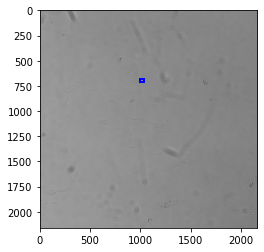

In [16]:
#@title Calculate bbox and display

ann = anns['annotations'][10]
print(ann)
ann['bbox'] = mutils.toBbox(coco.annToRLE(ann)).tolist()
images_path = 'dataverse_files/Images/EVICAN_train2019/11_769p.jpg'
image = Image.open(images_path)
 
fig, ax = plt.subplots()
 
# Draw boxes and add label to each box
# for ann in anns:
box = ann['bbox']
bb = patches.Rectangle((box[0],box[1]), box[2],box[3], linewidth=2, edgecolor="blue", facecolor="none")
ax.add_patch(bb)
 
ax.imshow(image)
plt.show()

In [4]:
#@title Loading out Evican2 COCO Dataset 

from detectron2.data.datasets import register_coco_instances

root_dir = '/content/drive/MyDrive/InstanceSegmentation/Dataset/dataverse_files/'
annotations_dir = 'annotations_EVICAN2/'

register_coco_instances("my_dataset_train", {}, root_dir+annotations_dir+"instances_train2019_EVICAN2_bbox.json", root_dir+'Images/EVICAN_train2019')
register_coco_instances("my_dataset_val", {}, root_dir+annotations_dir+"instances_val2019_EVICAN2_bbox.json", root_dir+'Images/EVICAN_val2019')
register_coco_instances("my_dataset_eval", {}, root_dir+annotations_dir+"instances_eval2019_medium_EVICAN2_bbox.json", root_dir+'Images/EVICAN_eval2019')

In [ ]:
#@title Creating our own custom Detectron2 Trainer to log Validation Loss

from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.engine import DefaultTrainer
from LossEvalHook import LossEvalHook 
import os
import numpy as np
import json
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

class CustomTrainer(DefaultTrainer):
    """
    Custom Trainer deriving from the "DefaultTrainer"
    Overloads build_hooks to add a hook to calculate val loss on the val set during training.
    """

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1, LossEvalHook(
            100, # Frequency of calculation - every 100 iterations here
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg, True)
            )
        ))

        return hooks

In [11]:
#@title Loading (detectron2) mask_rcnn_X_101_32x8d_FPN_3x.yaml and Training Model for upto 3000 itr


cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/InstanceSegmentation/detectron2/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

cfg.merge_from_file("/content/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")

cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.TEST.EVAL_PERIOD = 100
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = ("/content/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")

cfg.INPUT.MAX_SIZE_TEST = 20000
cfg.INPUT.MAX_SIZE_TRAIN = 20000
cfg.SOLVER.IMS_PER_BATCH = 2   # increase this for more speed, but it will need more vram
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
#cfg.SOLVER.BASE_LR = 0.000001  # pick a good LR /content/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4096   # or 128 for example
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 
cfg.SNAPSHOT_ITERS = 50 # when checkpoint gets created
cfg.SOLVER.CHECKPOINT_PERIOD = 50

# print(cfg.dump())  
with open("/content/drive/MyDrive/Self_Learning/detectron2/custom_mask_rcnn_X_101_32x8d_FPN_3x.yaml", "w") as f:
    f.write(cfg.dump())
    f.close()

trainer = CustomTrainer(cfg) 
# trainer.resume_or_load(resume=False)
trainer.train()

[10/01 20:21:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

KeyboardInterrupt: ignored

In [5]:
#@title Loading model for Evaluation on Eval/Test Dataset 
import iopath
from detectron2.engine import DefaultPredictor

cfg = get_cfg()
cfg.OUTPUT_DIR = "output/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


cfg.merge_from_file("detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = ("detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.INPUT.MAX_SIZE_TEST = 20000
cfg.SOLVER.IMS_PER_BATCH = 2   # increase this for more speed, but it will need more vram
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4096   # or 128 for example
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 

cfg.MODEL.WEIGHTS = 'output/model_best.pth'

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.00  # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_eval", )
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


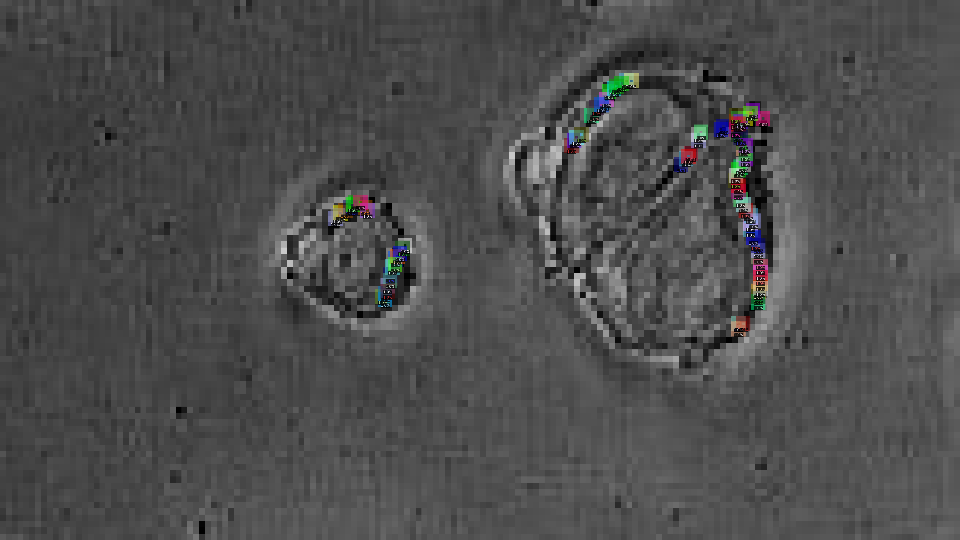

In [6]:
#@title do detection and display result
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import cv2
from google.colab.patches import cv2_imshow


im = cv2.imread("dataverse_files/Images/EVICAN_eval2019/100_SKBR.jpg")
outputs = predictor(im)
# print(outputs)
v = Visualizer(im[:, :, ::-1],
                metadata=None, 
                scale=30, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(cv2.resize(v.get_image()[:, :, ::-1], (960, 540)) )

In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import cv2

os.makedirs('out_images/', exist_ok=True)
evalImages = 'dataverse_files/Images/EVICAN_eval2019/'
for imName in os.listdir(evalImages):
    im = cv2.imread(evalImages+imName)
    outputs = predictor(im)
    # print(outputs)
    v = Visualizer(im[:, :, ::-1],
                    metadata=None, 
                    scale=30, 
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    out_file_name = 'out_images/'+imName
    cv2.imwrite(out_file_name, cv2.resize(v.get_image()[:, :, ::-1], (960, 540)))

In [5]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

evaluator = COCOEvaluator("my_dataset_eval", cfg, False, output_dir="output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_eval")
inference_on_dataset(predictor.model, val_loader, evaluator)

/usr/local/lib/python3.7/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.027
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.066
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.030
 Average Recall     (AR) @[ IoU=0.50:0.

OrderedDict([('bbox',
              {'AP': 0.17254292975408037,
               'AP50': 1.1195842724364529,
               'AP75': 0.0,
               'APs': 0.8763554926921263,
               'APm': 0.5047392466930145,
               'APl': 0.07444822860965505,
               'AP-Cell': 0.33549550320508437,
               'AP-Nucleus': 0.009590356303076326}),
             ('segm',
              {'AP': 0.014488106223065712,
               'AP50': 0.09535973043070121,
               'AP75': 0.0,
               'APs': 0.4555634134842054,
               'APm': 0.007241045682282121,
               'APl': 0.012912911569183397,
               'AP-Cell': 0.027541556783242587,
               'AP-Nucleus': 0.0014346556628888325})])